### Imports

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
%matplotlib inline

### DataPrep

In [2]:
# Reading the dataset

with open("./data/sample.txt",'rb') as f:
    df = json.load(f)

In [3]:
# Since I want to forecast sales on a week basis, it doesn`t matter if the products are in the same sale 
# or in a different one, although I could use this information on a future study


sales = pd.DataFrame([dict(list(product['prod'].items()) + 
              list(sale['ide']['dhEmi'].items())) 
        for sale in df for product in sale['dets']])

sales.loc[:,'$date'] = pd.to_datetime(sales.loc[:,'$date'])

In [4]:
sales.head()

,$date,indTot,qCom,uCom,vProd,vUnCom,xProd
0,2016-01-05 12:01:54,1,1.000,UN,3.50,3.5,AGUA
1,2016-01-05 12:01:54,1,0.312,KG,21.40,68.6,BUFFET
2,2016-01-05 12:03:52,1,1.218,KG,83.55,68.6,BUFFET
3,2016-01-05 12:03:52,1,2.000,UN,9.00,4.5,REFRIGERANTE
4,2016-01-05 12:16:40,1,1.000,UN,4.50,4.5,SUCO


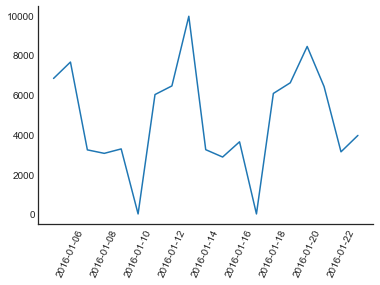

In [5]:
# For simplicity I will use just the total value of each product grouped by day

grouped_df = sales.groupby(pd.Grouper(key='$date', freq='D')).vProd.sum()
grouped_df.fillna(0, inplace=True)

plt.plot(grouped_df)
sns.despine()
plt.xticks(rotation=65)
plt.show()

### Modeling

For forecasting I like to use fbprophet that deals with real data, fiting linear models on general trending and on weekly, monthly and yearly seasonality.
Since this dataset only contains data from one month, I will fit the model only on general trending and weekly seasonality.

Another way of doing this is transforming the problem in a supervised machine learning problem, using a rolling window over a given timeframe as input and the next week's total of sales as target. In this schema, the dataset can be divided in training and validation and different regression techniques can be used to find the best model to forecast.

Given the nature and volume of the data, I'd rather using fbprophet.

In [6]:
from fbprophet import Prophet

In [7]:
# Fiting the data and predicting the next week sales
df_train = pd.DataFrame({'ds' : grouped_df.index , 'y' : grouped_df}).reset_index(drop=True)
m = Prophet(yearly_seasonality=False, daily_seasonality=False,n_changepoints= 10).fit(df_train)
future = m.make_future_dataframe(periods=7, freq='D')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
21,2016-01-26,7499.824645,6824.883324,8239.723161
22,2016-01-27,9557.803300,8803.328769,10330.898037
23,2016-01-28,5157.958830,4447.096953,5860.317133
24,2016-01-29,3875.399507,3168.644400,4709.678314
25,2016-01-30,4481.633574,3678.328000,5251.205537


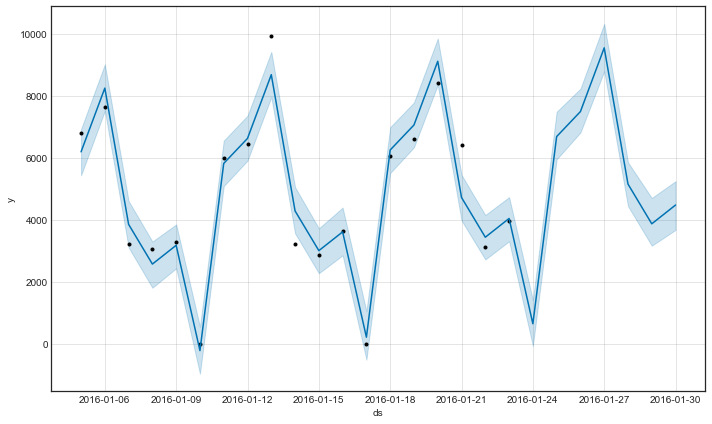

In [8]:
# Ploting the fits and confidence interval for the data we have and for the next week forecast.
m.plot(forecast);

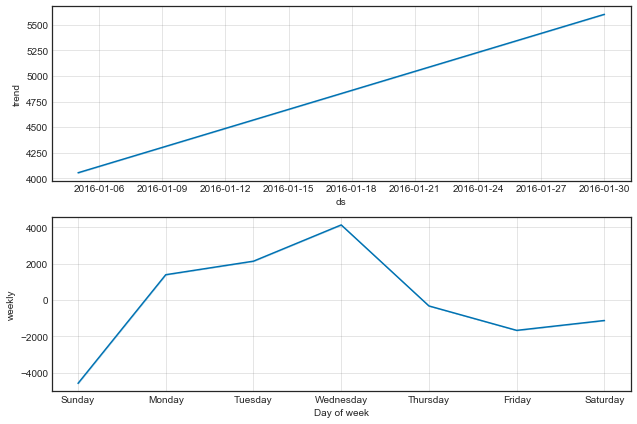

In [9]:
# Ploting components used on the prediction
m.plot_components(forecast);

In [10]:
print('Next Week sales forecast R$%0.2f' % np.sum(forecast[-7:].yhat))

Next Week sales forecast R$37912.17
